In [ ]:
! pip install -U transformers
! pip install datasets sentence-transformers evaluate
! pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_trans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import time
import re
from tqdm import notebook
import json

import seaborn as sns
import matplotlib.pyplot as plt

import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import r2_score

from datasets import Dataset
import evaluate

from sentence_transformers import SentenceTransformer, models, util

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

## Setting random seeed.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [ ]:
SEED = 97
seed_everything(SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


# Dataset load and process.

1. Load selected dataset for variability analysis.
2. Split into train, test and val sets.
3. Get sentence embeddings for each train sample (try sampling for each label separately).

Task - write a method for loading the dataset

In [ ]:
# def get_sst2_dataset_dfs(test_size=0.1):
#   dataset = load_dataset('sst2', 'binary')
#   train_df = dataset['train'].to_pandas().dropna()[['sentence', 'label']]
#   test_df = dataset['test'].to_pandas().dropna()[['sentence', 'label']]
#   val_df = dataset['validation'].to_pandas().dropna()[['sentence', 'label']]

#   return train_df, val_df, test_df

def get_sst2_dataset_dfs(test_size=0.1):
  dataset = load_dataset('sst2', 'binary')
  df = dataset['train'].to_pandas().dropna()

  X_train, X_temp, y_train, y_temp = train_test_split(df[['idx', 'sentence']], df.label, test_size=test_size*2, random_state=SEED, stratify=df.label)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

  train_df = X_train[['sentence']].copy().reset_index(drop=True)
  val_df = X_val[['sentence']].copy().reset_index(drop=True)
  test_df = X_test[['sentence']].copy().reset_index(drop=True)

  train_df['label'] = y_train.tolist()
  val_df['label'] = y_val.tolist()
  test_df['label'] = y_test.tolist()

  return train_df, val_df, test_df

In [ ]:
def get_imdb_dataset_dfs():
  dataset = load_dataset('imdb')
  train_df = dataset['train'].to_pandas().dropna()
  train_df.columns = ['sentence', 'label']

  test_df = dataset['test'].to_pandas().dropna()
  test_df.columns = ['sentence', 'label']

  return train_df, test_df

# Load Embeddings model

In [ ]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

In [ ]:
def get_embeddings(data):
    return embedder.encode(data, convert_to_tensor=True)

# Variance Utilities

In [ ]:
# embeddings -> (25000, 384) -> (25000, 100)
def get_self_variance(embeddings, n_components=100):
  pca = PCA(n_components=n_components)
  principal_components = pca.fit_transform(embeddings)

  # how much of the variance or information you were able to retain

  explained_variance_ratio = pca.explained_variance_ratio_
  # explained_variance_ratio = size -> (100, ) # sorted in descending order
  return np.sum(explained_variance_ratio), explained_variance_ratio

In [ ]:
# embeddings -> (25000, 384)
def get_variance_measures(embeddings, step=10, n_components=100):
  rng = np.random.default_rng()

  r2_values = []
  self_exp_vars = []
  subset_sizes = []
  rand_subsets_indices = []
  indices = np.arange(embeddings.shape[0])

  step_size = len(embeddings)//step

  for n in notebook.tqdm(range(step_size, len(embeddings)+1, step_size)):
    subset_sizes.append(n)
    pca = PCA(n_components=n_components)

    subset_indices = rng.choice(indices, n, replace=False)
    rand_subsets_indices.append(subset_indices)

    # 1st iteration -> (2500, 384) pca on the subset
    principal_components = pca.fit_transform(embeddings[subset_indices])

    explained_variance_ratio = pca.explained_variance_ratio_

    expl_var = np.sum(explained_variance_ratio)
    self_exp_vars.append(expl_var)

    # pca.transform(embeddings) -> (25000, 100)
    # pca.inverse_transform(pca.transform(embeddings)) - (25000, 100) -> (25000, 384)

    r2_values.append(r2_score(embeddings, pca.inverse_transform(pca.transform(embeddings)), multioutput='variance_weighted'))

  return self_exp_vars, r2_values, subset_sizes, rand_subsets_indices

In [ ]:
def plot_variance_measure(subset_sizes, r2_values, full_set_var):
  graph = sns.lineplot(x=subset_sizes, y=r2_values, marker="o")
  graph.axhline(full_set_var, color='red')
  plt.show()

In [ ]:
def plot_variance_measure_extra(subset_sizes, r2_values, full_set_var, self_expl_vars):
  r2_values.insert(0, 0)
  subset_sizes.insert(0, 0)
  graph = sns.lineplot(x=subset_sizes, y=r2_values, marker="o")
  sns.lineplot(x=subset_sizes, y=self_expl_vars, marker="o")
  graph.axhline(full_set_var, color='red')
  plt.show()

# Variance Analysis

## SST2

In [ ]:
train_df_sst, val_df_sst, test_df_sst = get_sst2_dataset_dfs()

In [ ]:
# convert sentences to vectors of size 384
sentence_embeddings_sst = get_embeddings(train_df_sst['sentence'].values).detach().cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

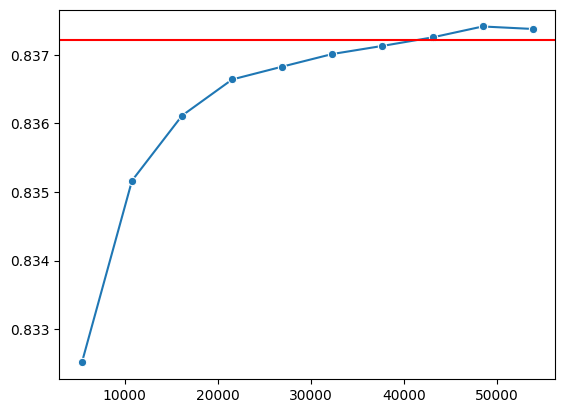

In [ ]:
full_set_var_sst, explained_variance_ratio_sst = get_self_variance(sentence_embeddings_sst)
self_expl_vars_sst, r2_values_sst, subset_sizes_sst, rand_subset_indices_sst = get_variance_measures(sentence_embeddings_sst)
plot_variance_measure(subset_sizes_sst, r2_values_sst, full_set_var_sst)

## IMDB

In [ ]:
train_df_imdb, test_df_imdb = get_imdb_dataset_dfs()

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
sentence_embeddings_imdb = get_embeddings(train_df_imdb['sentence'].values).detach().cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

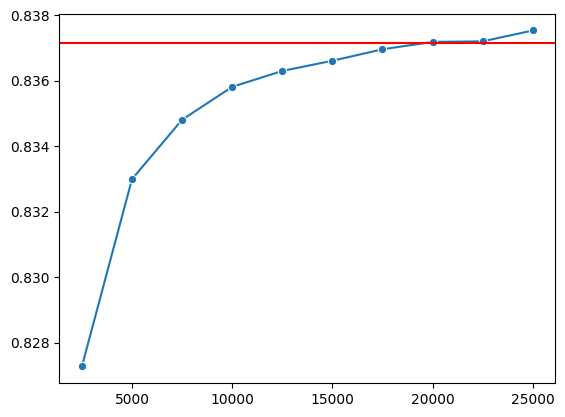

In [ ]:
full_set_var_imdb, explained_variance_ratio_imdb = get_self_variance(sentence_embeddings_imdb)
self_expl_vars_imdb, r2_values_imdb, subset_sizes_imdb, rand_subset_indices_imdb = get_variance_measures(sentence_embeddings_imdb)
plot_variance_measure(subset_sizes_imdb, r2_values_imdb, full_set_var_imdb)

In [ ]:
subset_sizes_imdb

[2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]

# Modelling

In [ ]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
SAVE_MODEL_PATH = "/content/drive/MyDrive/Representative Subset/Models"
SAVE_LOGS_PATH = "/content/drive/MyDrive/Representative Subset/Logs"
LEARNING_RATE = 5e-5
EPOCHS = 3

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["sentence"],
                     max_length=MAX_LEN,
                     truncation=True,
                     padding="max_length"
                     )

In [ ]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# Define model
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

In [ ]:
def get_hf_dataset(df):
  data = Dataset.from_pandas(df)
  dataset = data.map(tokenize_dataset)
  return dataset

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir=SAVE_MODEL_PATH,
    logging_dir=SAVE_LOGS_PATH,
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [ ]:
def train_on_subsets(subset_sizes, subset_indices_list, train_df, test_df, val_df=None):

  sizes = []
  test_accuracies = []
  test_losses = []

  test_dataset = get_hf_dataset(test_df)
  if val_df is not None:
    val_dataset = get_hf_dataset(val_df)
  else:
    val_dataset = get_hf_dataset(test_df.copy())

  for i in range(len(subset_sizes)):
    # subset_indices -> (2500, )
    subset_indices = subset_indices_list[i]
    # subset_train_df -> len = 2500
    subset_train_df = train_df.loc[subset_indices].reset_index(drop=True)
    subset_train_df.columns = ['sentence', 'label']

    train_dataset = get_hf_dataset(subset_train_df)

    trainer = Trainer(
      model_init=model_init,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()

    test_predict_result = trainer.predict(test_dataset)

    test_accuracies.append(test_predict_result.metrics['test_accuracy'])
    test_losses.append(test_predict_result.metrics['test_loss'])

    print(f"For subset: {subset_sizes[i]} -> Test Accuracy: {test_predict_result.metrics['test_accuracy']}, Test Loss: {test_predict_result.metrics['test_loss']}\n")

    sizes.append(subset_sizes[i])
    trainer.save_model(f"/content/drive/MyDrive/CS567-ML/SST2/Subset-Models/model-{subset_sizes[i]}")

  return sizes, test_accuracies, test_losses

In [ ]:
def plot_stats(subset_sizes, test_accuracies, test_losses):
  sns.lineplot(x=subset_sizes, y=test_accuracies, marker="o")
  # sns.lineplot(x=subset_sizes, y=test_losses, marker="o")
  plt.show()

In [ ]:
# sizes, test_accuracies, test_losses = train_on_subsets(subset_sizes_sst, rand_subset_indices_sst, train_df_sst, val_df_sst, test_df_sst)

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/5387 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.365800,0.252211,0.894729
2,0.139700,0.296375,0.906310


For subset: 5387 -> Test Accuracy: 0.9012620638455828, Test Loss: 0.24481013417243958



Map:   0%|          | 0/10774 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.312200,0.233609,0.908389
2,0.116200,0.260331,0.919079


For subset: 10774 -> Test Accuracy: 0.9101707498144024, Test Loss: 0.22514954209327698



Map:   0%|          | 0/16161 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.280600,0.221612,0.921010
2,0.120300,0.257892,0.925464


For subset: 16161 -> Test Accuracy: 0.9290274684484039, Test Loss: 0.19588437676429749



Map:   0%|          | 0/21548 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.271400,0.218603,0.927691
2,0.105800,0.213834,0.930364
3,0.046400,0.286695,0.936451


For subset: 21548 -> Test Accuracy: 0.9352635486265776, Test Loss: 0.19482144713401794



Map:   0%|          | 0/26935 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.252200,0.197311,0.926503
2,0.103900,0.222943,0.932591


For subset: 26935 -> Test Accuracy: 0.9367483296213809, Test Loss: 0.16971881687641144



Map:   0%|          | 0/32322 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.248400,0.188646,0.929473
2,0.106100,0.222709,0.937342


For subset: 32322 -> Test Accuracy: 0.9368968077208611, Test Loss: 0.16620075702667236



Map:   0%|          | 0/37709 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.240600,0.184687,0.933779
2,0.108400,0.200578,0.941351


For subset: 37709 -> Test Accuracy: 0.9394209354120268, Test Loss: 0.16716168820858002



Map:   0%|          | 0/43096 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.234400,0.179340,0.937194
2,0.111500,0.181210,0.945509


For subset: 43096 -> Test Accuracy: 0.9419450631031923, Test Loss: 0.15735256671905518



Map:   0%|          | 0/48483 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.222200,0.209668,0.932591
2,0.106200,0.189077,0.944172
3,0.054800,0.226885,0.945657


For subset: 48483 -> Test Accuracy: 0.9505567928730512, Test Loss: 0.16335763037204742



Map:   0%|          | 0/53870 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


FailedPreconditionError: ignored

In [ ]:
SAVED_MODELS_PATH = "/content/drive/MyDrive/CS567-ML/SST2/Subset-Models"

In [ ]:
test_dataset = get_hf_dataset(test_df_sst)

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

In [ ]:
temp_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    per_device_eval_batch_size=32   # batch size for evaluation
)

In [ ]:
import gc

In [ ]:
test_accuracies = []
test_losses = []
for size in subset_sizes_sst[:len(subset_sizes_sst)-1]:
  model = AutoModelForSequenceClassification.from_pretrained(f"{SAVED_MODELS_PATH}/model-{size}").to(device)
  trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=temp_training_args,                  # training arguments, defined above
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )

  # Evaluate the model
  eval_result = trainer.evaluate(eval_dataset=test_dataset)
  test_accuracies.append(eval_result['eval_accuracy'])
  test_losses.append(eval_result['eval_loss'])

  del model
  gc.collect()

In [ ]:
test_accuracies, test_losses

([0.8947290274684484,
  0.9083890126206384,
  0.9210096510764663,
  0.9303637713437268,
  0.9265033407572383,
  0.9294729027468448,
  0.9337787676317744,
  0.9371937639198218,
  0.9441722345953972],
 [0.2522113621234894,
  0.23360879719257355,
  0.2216118425130844,
  0.21383436024188995,
  0.19731098413467407,
  0.18864569067955017,
  0.18468749523162842,
  0.1793401539325714,
  0.18907739222049713])

In [ ]:
sizes_last, test_accuracies_last, test_losses_last = train_on_subsets([subset_sizes_sst[-1]], [rand_subset_indices_sst[-1]], train_df_sst, val_df_sst, test_df_sst)

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/53870 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.220900,0.227948,0.938085
2,0.104800,0.199769,0.946548


Epoch,Training Loss,Validation Loss,Accuracy
1,0.220900,0.227948,0.938085
2,0.104800,0.199769,0.946548
3,0.056400,0.226343,0.946102


For subset: 53870 -> Test Accuracy: 0.9521900519673349, Test Loss: 0.1765681803226471



In [ ]:
test_accuracies.append(test_accuracies_last[0])
test_losses.append(test_losses_last[0])

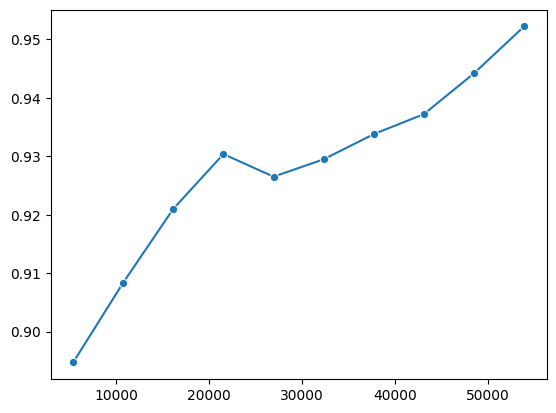

In [ ]:
plot_stats(subset_sizes_sst, test_accuracies, test_losses)

In [ ]:
def save_metrics(filePath, variance_metrics, modelling_metrics):
  metrics = {'variance_metrics': variance_metrics, 'modelling_metrics': modelling_metrics}
  with open(filePath, "w") as outfile:
      json.dump(metrics, outfile)

In [ ]:
variance_metrics_sst = {
    'full_set_var_sum': full_set_var_sst.astype(float),
    'full_set_var_values': [val.astype(float) for val in explained_variance_ratio_sst],
    'subsets_self_expl_vars': [val.astype(float) for val in self_expl_vars_sst],
    'r2_values': r2_values_sst,
    'subset_sizes': subset_sizes_sst
}
modelling_metrics_sst = {
    'subset_size': subset_sizes_sst,
    'test_accuracies': test_accuracies,
    'test_losses': test_losses
}
save_metrics("/content/drive/MyDrive/CS567-ML/SST2/run-metrics.json", variance_metrics_sst, modelling_metrics_sst)